<a href="https://colab.research.google.com/github/FrancescaPorcellii/AML/blob/main/gesture_recognition_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [4]:
!unzip -q "/content/dataset-hands.zip" -d "/content/dataset_hands"

replace /content/dataset_hands/dataset-hands/0/10_Color.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Landmark Extraction

In [53]:
import os
import cv2
import mediapipe as mp
import numpy as np
import csv

# --- Parametri ---
DATASET_DIR = "/content/dataset_hands/dataset-hands/3"
output_csv = "3_augmented.csv"
output_npy = "3_augmented.npy"
radius = 4  # per la media attorno al punto depth

# --- Funzione per profondità valida ---
def get_valid_depth_avg(depth_map, x, y, radius=4):
    h, w = depth_map.shape
    values = []
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                d = depth_map[ny, nx]
                if d > 0:
                    values.append(d)
    return np.mean(values) if values else 0.0

# --- Setup MediaPipe ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# Header CSV
header = [f'{dim}{i}_R' for i in range(21) for dim in ['x', 'y', 'z']]
header += [f'{dim}{i}_L' for i in range(21) for dim in ['x', 'y', 'z']]

# Output
all_landmarks = []
count_right = count_left = count_total = 0

with open(output_csv, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(header)

    for filename in sorted(os.listdir(DATASET_DIR)):
        if not filename.endswith("_Color.png"):
            continue

        base_name = filename.replace("_Color.png", "")
        depth_raw_path = os.path.join(DATASET_DIR, f"{base_name}_Depth.raw")
        image_path = os.path.join(DATASET_DIR, filename)
        depth_png_path = os.path.join(DATASET_DIR, f"{base_name}_Depth.png")

        # Carica immagine
        image_bgr = cv2.imread(image_path)
        depth_png = cv2.imread(depth_png_path)
        if image_bgr is None or not os.path.exists(depth_raw_path):
            print(f"❌ Errore file: {filename}")
            continue

        height, width, _ = depth_png.shape
        depth_raw = np.fromfile(depth_raw_path, dtype=np.uint16)
        depth_map = depth_raw.reshape((240, 320))  # height, width
        print(depth_raw.size)
        if depth_raw.size != height * width:
            print(f"⚠️ Dimensione depth non corretta per {filename}")
            continue
        depth_map = depth_raw.reshape((height, width)).astype(np.float32) / 10000.0  # in metri

        for flip in [False, True]:
            img_proc = cv2.flip(image_bgr, 1) if flip else image_bgr
            img_rgb = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)

            right_hand = [0.0] * (21 * 3)
            left_hand = [0.0] * (21 * 3)

            if results.multi_hand_landmarks and results.multi_handedness:
                for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                    label = handedness.classification[0].label
                    if label == "Right":
                        label = "Left"
                    else:
                        label = "Right"

                    landmarks = []
                    for lm in hand_landmarks.landmark:
                        x = lm.x
                        y = lm.y
                        px = min(int(x * width), width - 1)
                        py = min(int(y * height), height - 1)
                        z = get_valid_depth_avg(depth_map, px, py, radius=radius)  # z dalla depth
                        #z_norm = z / 2.0
                        landmarks.extend([x, y, z])

                    if label == "Right":
                        right_hand = landmarks
                        count_right += 1
                    else:
                        left_hand = landmarks
                        count_left += 1

            combined = right_hand + left_hand
            all_landmarks.append(combined)
            csv_writer.writerow(combined)
            count_total += 1

# Salva in npy
np.save(output_npy, np.array(all_landmarks))

# Statistiche finali
print(f"✅ Landmark salvati in {output_csv} e {output_npy}")
print(f"📊 Immagini totali analizzate (inclusi flip): {count_total}")
print(f"🖐️ Mani rilevate: Destra {count_right} | Sinistra {count_left}")
print(f"📁 Campioni totali: {len(all_landmarks)}")


76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800
76800


KeyboardInterrupt: 

In [37]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

def get_valid_depth_avg(depth_map, x, y, radius=50):
    h, w = depth_map.shape
    values = []

    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                d = depth_map[ny, nx]
                if d > 0:
                    values.append(d)

    if values:
        return np.mean(values)
    else:
        return 0.0  # oppure np.nan se vuoi trattarlo diversamente
# Percorsi file
color_img_path = "/content/dataset_hands/dataset-hands/3/10_Color.png"
depth_raw_path = "/content/dataset_hands/dataset-hands/3/10_Depth.raw"

# --- Carica immagine RGB ---
image_bgr = cv2.imread(color_img_path)
if image_bgr is None:
    raise Exception("Errore nel caricamento dell'immagine a colori")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

height, width, _ = image_bgr.shape

# --- Carica depth map dal file RAW ---
depth_raw = np.fromfile(depth_raw_path, dtype=np.uint16)
depth_map = depth_raw.reshape((240, 320))  # height, width
img = cv2.imread('/content/dataset_hands/dataset-hands/3/10_Depth.png')
height, width, _ = img.shape
print(f"Width: {width}, Height: {height}")
if depth_raw.size != height * width:
    raise Exception(f"Dimensioni raw depth non corrispondono a {height}x{width}")
depth_map = depth_raw.reshape((height, width))
# Converti depth da uint16 (mm) a float32 (metri)
depth_meters = depth_map.astype(np.float32) / 10000.0

# --- Setup MediaPipe Hands ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# --- Processa immagine ---
results = hands.process(image_rgb)

if not results.multi_hand_landmarks:
    print("Nessuna mano rilevata")
else:
    for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
        print(f"Mano {hand_idx+1}:")
        for i, lm in enumerate(hand_landmarks.landmark):
            # Posizione pixel landmark (x, y)
            px = min(int(lm.x * width), width - 1)
            py = min(int(lm.y * height), height - 1)

            # Profondità z da MediaPipe (normalizzata)
            z_mediapipe = lm.z

            # Profondità reale dalla depth map in metri

            z_real = get_valid_depth_avg(depth_meters, px, py)
            print(f"  Landmark {i}: (px={px}, py={py}) -> z_mediapipe={z_mediapipe:.4f}, z_real={z_real:.4f} m")

# Chiudi MediaPipe
hands.close()


Width: 320, Height: 240
Mano 1:
  Landmark 0: (px=139, py=200) -> z_mediapipe=0.0000, z_real=0.4543 m
  Landmark 1: (px=128, py=175) -> z_mediapipe=0.0401, z_real=0.4074 m
  Landmark 2: (px=123, py=152) -> z_mediapipe=0.0389, z_real=0.3819 m
  Landmark 3: (px=118, py=133) -> z_mediapipe=0.0314, z_real=0.3603 m
  Landmark 4: (px=111, py=121) -> z_mediapipe=0.0270, z_real=0.3576 m
  Landmark 5: (px=140, py=140) -> z_mediapipe=-0.0262, z_real=0.3961 m
  Landmark 6: (px=146, py=110) -> z_mediapipe=-0.0532, z_real=0.3711 m
  Landmark 7: (px=149, py=91) -> z_mediapipe=-0.0662, z_real=0.3892 m
  Landmark 8: (px=152, py=77) -> z_mediapipe=-0.0742, z_real=0.4169 m
  Landmark 9: (px=152, py=146) -> z_mediapipe=-0.0482, z_real=0.4412 m
  Landmark 10: (px=168, py=113) -> z_mediapipe=-0.0939, z_real=0.4505 m
  Landmark 11: (px=178, py=93) -> z_mediapipe=-0.1119, z_real=0.4523 m
  Landmark 12: (px=185, py=80) -> z_mediapipe=-0.1202, z_real=0.4751 m
  Landmark 13: (px=164, py=155) -> z_mediapipe=-0.0

### Add Augumentation

In [54]:
import os
import numpy as np

# === Funzioni di Data Augmentation ===

def flip_two_hands(landmarks_flat):
    """
    Trasforma un gesto fatto con la mano destra in uno fatto con la sinistra.
    Assunzione: input è [RH (21), LH (21)] — dove LH = 0.
    Output: [RH = 0, LH = RH_flipped]
    """
    landmarks = landmarks_flat.reshape((42, 3)).copy()

    # Flip orizzontale
    landmarks[:, 0] = 1.0 - landmarks[:, 0]

    # RH originali (0:21) → ora saranno LH (21:42)
    flipped_rh = landmarks[0:21]

    # Creiamo nuovo array
    new_landmarks = np.zeros_like(landmarks)  # Tutto a zero
    new_landmarks[21:] = flipped_rh  # Inseriamo RH flippata come se fosse LH

    return new_landmarks


def zoom_landmarks(landmarks, scale=0.8):
    center = landmarks[0]
    return (landmarks - center) * scale + center

def rotate_landmarks(landmarks, angle_deg=15):
    angle_rad = np.radians(angle_deg)
    center = landmarks[0]
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    rotated = np.dot(landmarks[:, :2] - center[:2], rotation_matrix) + center[:2]
    landmarks[:, :2] = rotated
    return landmarks

def translate_landmarks(landmarks, offset=(0.05, -0.03, 0.0)):
    return landmarks + np.array(offset)

# === Percorsi da modificare ===
input_base_dir = "/content/dataset_NOT_augmented"
output_base_dir = "/content/data_augumented"

os.makedirs(output_base_dir, exist_ok=True)

# === Elaborazione dei file ===
for file_name in sorted(os.listdir(input_base_dir)):
            augmented = [] # Initialize augmented here

            if file_name.endswith('.npy'):
                print(f"✔️ File: {file_name}")
                file_path = os.path.join(input_base_dir, file_name)
                landmarks = np.load(file_path)

                for i, landmark in enumerate(landmarks):
                  landmark = landmark.reshape((42, 3))  # (21 dx + 21 sx)
                  right = landmark[:21]
                  left = landmark[21:]


                  # Salva sempre l'originale
                  augmented.append(landmark.copy())



                  # === AUGMENTATION PARZIALE ===
                  # Zoom, rotazione, traslazione applicate solo alle mani presenti

                  # Zoom
                  zoomed = landmark.copy()
                  if not np.allclose(right, 0.0):
                      zoomed[:21] = zoom_landmarks(right.copy(), scale=0.8)
                  if not np.allclose(left, 0.0):
                      zoomed[21:] = zoom_landmarks(left.copy(), scale=0.8)
                  augmented.append(zoomed)

                  # Rotazione +15°
                  rotated_p15 = landmark.copy()
                  if not np.allclose(right, 0.0):
                      rotated_p15[:21] = rotate_landmarks(right.copy(), angle_deg=15)
                  if not np.allclose(left, 0.0):
                      rotated_p15[21:] = rotate_landmarks(left.copy(), angle_deg=15)
                  augmented.append(rotated_p15)

                  # Rotazione -15°
                  rotated_m15 = landmark.copy()
                  if not np.allclose(right, 0.0):
                      rotated_m15[:21] = rotate_landmarks(right.copy(), angle_deg=-15)
                  if not np.allclose(left, 0.0):
                      rotated_m15[21:] = rotate_landmarks(left.copy(), angle_deg=-15)
                  augmented.append(rotated_m15)

                  # Traslazione +
                  translated_p = landmark.copy()
                  if not np.allclose(right, 0.0):
                      translated_p[:21] = translate_landmarks(right.copy(), offset=(0.05, -0.03, 0.0))
                  if not np.allclose(left, 0.0):
                      translated_p[21:] = translate_landmarks(left.copy(), offset=(0.05, -0.03, 0.0))
                  augmented.append(translated_p)

                  # Traslazione -
                  translated_m = landmark.copy()
                  if not np.allclose(right, 0.0):
                      translated_m[:21] = translate_landmarks(right.copy(), offset=(-0.05, 0.03, 0.0))
                  if not np.allclose(left, 0.0):
                      translated_m[21:] = translate_landmarks(left.copy(), offset=(-0.05, 0.03, 0.0))
                  augmented.append(translated_m)

            else:
                print(f"⚠️ File non valido: {file_name}")

            print("augumented lenght: ", len(augmented))
            new_name = f"{os.path.splitext(file_name)[0]}.npy"
            save_path = os.path.join(output_base_dir, new_name)
            np.save(save_path, augmented)
            print(f"✔️ File salvato: {save_path}")

⚠️ File non valido: .ipynb_checkpoints
augumented lenght:  0
✔️ File salvato: /content/data_augumented/.ipynb_checkpoints.npy
✔️ File: 0.npy
augumented lenght:  822
✔️ File salvato: /content/data_augumented/0.npy
⚠️ File non valido: 0_augmented.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/0_augmented.npy
✔️ File: 1.npy
augumented lenght:  822
✔️ File salvato: /content/data_augumented/1.npy
⚠️ File non valido: 1_augmented.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/1_augmented.npy
✔️ File: 2.npy
augumented lenght:  822
✔️ File salvato: /content/data_augumented/2.npy
⚠️ File non valido: 2_augmented.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/2_augmented.npy
✔️ File: 3.npy
augumented lenght:  822
✔️ File salvato: /content/data_augumented/3.npy
⚠️ File non valido: 3_augmented.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/3_augmented.npy


In [ ]:
import shutil
from google.colab import files


# Crea un file ZIP chiamato data_augumented.zip a partire dalla cartella
shutil.make_archive("/content/data_augumented", 'zip', "/content/data_augumented")

# Scarica il file ZIP sul tuo computer
files.download("/content/data_augumented.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!git clone https://github.com/Cloud2602/gesture_recognition.git

Cloning into 'gesture_recognition'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (379/379), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 379 (delta 157), reused 282 (delta 97), pack-reused 0 (from 0)
Receiving objects: 100% (379/379), 39.02 MiB | 8.30 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Updating files: 100% (262/262), done.


In [52]:
rm -rf /content/data_augumented

In [ ]:
%cd /content/gesture_recognition
!git pull

/content/gesture_recognition
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 66 (delta 23), reused 51 (delta 12), pack-reused 0 (from 0)
Unpacking objects: 100% (66/66), 703.60 KiB | 2.67 MiB/s, done.
From https://github.com/Cloud2602/gesture_recognition
   c5ef690..c453b07  main       -> origin/main
Updating c5ef690..c453b07
Fast-forward
 .gitignore                                         |   3 +-
 .vsconfig                                          |   6 +
 Assets/.vs/slnx.sqlite                             | Bin 0 -> 90112 bytes
 Assets/Scenes/WebcamIntegration.unity              | 588 +++++++++++++++++++++
 Assets/Scenes/WebcamIntegration.unity.meta         |   7 +
 Assets/Scripts.meta                                |   8 +
 Assets/Scripts/HeartRotator.cs                     |  42 ++
 Assets/Scripts/HeartRotator.cs.meta                |  11 +
 Assets/WebcamDisplay.cs                  

In [ ]:
!pip install tensorflow

In [ ]:
%cd ..

/content


In [ ]:
!unzip dataset_NOT_augmented.zip

Archive:  dataset_NOT_augmented.zip
   creating: dataset_NOT_augmented/
  inflating: dataset_NOT_augmented/0.npy  
  inflating: dataset_NOT_augmented/1.npy  
  inflating: dataset_NOT_augmented/2.npy  
  inflating: dataset_NOT_augmented/3.npy  


In [ ]:
!python /content/gesture_recognition/train.py

2025-06-23 14:07:57.931478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750687677.986605   16927 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750687678.000082   16927 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 14:07:58.052457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_d

In [58]:
import numpy as np

# === Caricamento ===
data = np.load("/content/data_augumented/3.npy")
print(f"🔢 Sample totali iniziali: {len(data)}")

# === Filtra i sample
filtered = []
for i, sample in enumerate(data):
    sample = sample.reshape((42, 3))

    right = sample[:21]
    left = sample[21:]

    right_zero = np.allclose(right, 0.0)
    left_zero = np.allclose(left, 0.0)

    if right_zero and left_zero:
        print(f"🗑️  Sample {i} rimosso: TUTTO ZERO")
        continue  # Skip questo sample

    filtered.append(sample)

# === Salva sopra a 1.npy
filtered = np.array(filtered)
np.save("/content/data_augumented/3.npy", filtered)
print(f"\n✅ Nuovo file salvato: {len(filtered)} sample scritti in '3.npy'")


🔢 Sample totali iniziali: 822

✅ Nuovo file salvato: 822 sample scritti in '3.npy'


In [59]:
import numpy as np

# === Caricamento ===
data = np.load("/content/data_augumented/3.npy")  # Assicurati che il file sia nel path corrente
print(f"🔢 Numero totale di sample: {len(data)}")

s=0
d=0
t=0
# === Analisi ===
for i, sample in enumerate(data):
    sample = sample.reshape((42, 3))  # 21 destra + 21 sinistra
    right = sample[:21]
    left = sample[21:]
    #print(f"Sample {i}: RIGHT: {right}, LEFT: {left}")

    right_zero = np.allclose(right, 0.0)
    left_zero = np.allclose(left, 0.0)

    if right_zero and not left_zero:
        s=s+1
        print(f"\n🖐️ Sample {i}: SOLO MANO SINISTRA")
    elif not right_zero and left_zero:
        d=d+1
        print(f"\n👉 Sample {i}: SOLO MANO DESTRA")
    elif not right_zero and not left_zero:
        t=t+1
        print(f"\n🤲 Sample {i}: DUE MANI")
    else:
        print(f"\n⚠️ Sample {i}: TUTTO ZERO (forse errore)")

print("mani sinistre", s)
print("mani destra", d)
print("due mani", t)

🔢 Numero totale di sample: 822

👉 Sample 0: SOLO MANO DESTRA

👉 Sample 1: SOLO MANO DESTRA

👉 Sample 2: SOLO MANO DESTRA

👉 Sample 3: SOLO MANO DESTRA

👉 Sample 4: SOLO MANO DESTRA

👉 Sample 5: SOLO MANO DESTRA

🖐️ Sample 6: SOLO MANO SINISTRA

🖐️ Sample 7: SOLO MANO SINISTRA

🖐️ Sample 8: SOLO MANO SINISTRA

🖐️ Sample 9: SOLO MANO SINISTRA

🖐️ Sample 10: SOLO MANO SINISTRA

🖐️ Sample 11: SOLO MANO SINISTRA

👉 Sample 12: SOLO MANO DESTRA

👉 Sample 13: SOLO MANO DESTRA

👉 Sample 14: SOLO MANO DESTRA

👉 Sample 15: SOLO MANO DESTRA

👉 Sample 16: SOLO MANO DESTRA

👉 Sample 17: SOLO MANO DESTRA

🖐️ Sample 18: SOLO MANO SINISTRA

🖐️ Sample 19: SOLO MANO SINISTRA

🖐️ Sample 20: SOLO MANO SINISTRA

🖐️ Sample 21: SOLO MANO SINISTRA

🖐️ Sample 22: SOLO MANO SINISTRA

🖐️ Sample 23: SOLO MANO SINISTRA

👉 Sample 24: SOLO MANO DESTRA

👉 Sample 25: SOLO MANO DESTRA

👉 Sample 26: SOLO MANO DESTRA

👉 Sample 27: SOLO MANO DESTRA

👉 Sample 28: SOLO MANO DESTRA

👉 Sample 29: SOLO MANO DESTRA

🖐️ Sample 30

✅ Modello caricato!


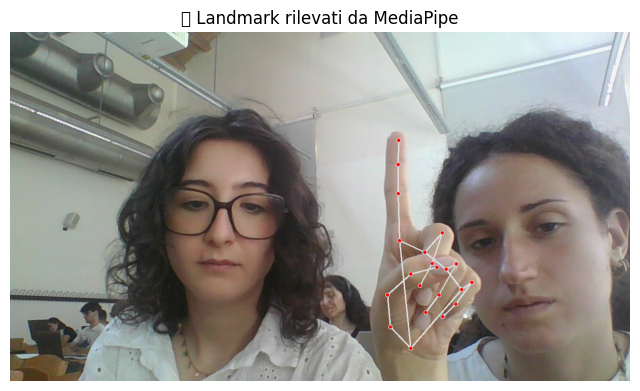

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
📈 Output del modello: [[0.8575808  0.02611466 0.05110741 0.06519715]]
🔢 Classe predetta: 0


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# === CONFIGURAZIONE ===
model_path = '/content/best_model.h5'
image_path = '/content/WIN_20250623_12_57_23_Pro.jpg'  # <-- Cambia con il tuo file
input_size = 126  # 21 punti x 3 coordinate x 2 mani

# === CARICA MODELLO ===
model = load_model(model_path)
print("✅ Modello caricato!")

# === SETUP MEDIAPIPE ===
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# === CARICA IMMAGINE ===
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError(f"❌ Immagine non trovata: {image_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === ESTRAZIONE LANDMARK ===
results = hands.process(image_rgb)

# Landmark inizializzati a zero (come nel training)
right_hand = [0.0] * (21 * 3)
left_hand = [0.0] * (21 * 3)
annotated_image = image_bgr.copy()
if results.multi_hand_landmarks and results.multi_handedness:
    for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
        mp_drawing.draw_landmarks(
              annotated_image,
              hand_landmarks,
              mp_hands.HAND_CONNECTIONS
          )
        label = handedness.classification[0].label  # "Left" o "Right"
        if label == "Right":
          label= "Left"
        else:
          label= "Right"
        landmarks = []
        for lm in hand_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
        if label == "Right":
            right_hand = landmarks
        elif label == "Left":
            left_hand = landmarks


# === MOSTRA IMMAGINE CON LANDMARK ===
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("🖐️ Landmark rilevati da MediaPipe")
plt.axis("off")
plt.show()

# === COMBINA E PREPARA INPUT ===
combined = right_hand + left_hand
input_data = np.array([combined])  # shape: (1, 126)

# === PREDIZIONE ===
prediction = model.predict(input_data)
predicted_class = np.argmax(prediction)

# === RISULTATI ===
print("📈 Output del modello:", prediction)
print("🔢 Classe predetta:", predicted_class)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, np.argmax(y_train, axis=1))
print("Test accuracy:", clf.score(X_test, np.argmax(y_test, axis=1)))
